In [ ]:
!pip list
# API key 4a7bd54cce4d729539676545b2584e47f11ebba1

Package                                  Version
---------------------------------------- --------------------
absl-py                                  1.4.0
absolufy-imports                         0.3.1
accelerate                               1.11.0
aiofiles                                 24.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aiosignal                                1.4.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.2
altair                                   5.5.0
annotated-doc                            0.0.4
annotated-types                          0.7.0
antlr4-python3-runtime                   4.9.3
anyio                                    4.11.0
anywidget                                0.9.21
argon2-cffi                        

In [ ]:

!pip install kaggle

In [ ]:
!pip install --upgrade transformers

In [ ]:
import transformers
print(transformers.__version__)

4.57.1


In [2]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"priyanshuroy0512","key":"033fb73a362fd945908fe3ff6275e794"}'}

In [3]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)


In [4]:
!kaggle datasets download -d prabhatamgain/phishing-and-legit-emails

Dataset URL: https://www.kaggle.com/datasets/prabhatamgain/phishing-and-legit-emails
License(s): MIT
phishing-and-legit-emails.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
import os

zip_file_path = '/content/phishing-and-legit-emails.zip'
extract_dir = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"'{zip_file_path}' unzipped to '{extract_dir}'")
print(os.listdir(extract_dir))

'/content/phishing-and-legit-emails.zip' unzipped to '/content/'
['.config', 'truncated_svd.pkl', '.ipynb_checkpoints', 'cleanformodels.csv', 'phishing-and-legit-emails.zip', 'count_vectorizer.pkl', 'new_clean_email.csv', 'sample_data']


In [6]:
# 📦 Setup
import pandas as pd
import numpy as np
import torch
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding,
    EarlyStoppingCallback
)
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
df = pd.read_csv("/content/cleanformodels.csv")
df.head()

,label,urls,hour,day_of_week,sender_username,sender_domain,text
0,1,1,23,1,young,iworld.de,never agree to be a loser buck up your trouble...
1,1,1,23,1,s1983,icable.ph,befriend jenna jameson upgrade your sex and pl...
2,1,1,8,2,karmandeep-opengevl,universalnet.psi.br,cnncom daily top 10 the daily top 10 from cnnc...
3,0,1,23,1,ivqrnai,pobox.com,re svn commit r619753 in spamassassintrunk lib...
4,1,1,23,1,externalsep1,loanofficertool.com,specialpricespharmmoreinfo welcomefastshipping...


In [8]:
df.shape

(38164, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38164 entries, 0 to 38163
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            38164 non-null  int64 
 1   urls             38164 non-null  int64 
 2   hour             38164 non-null  int64 
 3   day_of_week      38164 non-null  int64 
 4   sender_username  38164 non-null  object
 5   sender_domain    38164 non-null  object
 6   text             38164 non-null  object
dtypes: int64(4), object(3)
memory usage: 2.0+ MB


In [10]:
df.tail()

,label,urls,hour,day_of_week,sender_username,sender_domain,text
38159,1,0,14,4,charlene-detecton,btcmarketing.com,cnn alerts my custom alert cnn alerts my custo...
38160,1,0,14,4,idgetily1971,careplusnj.org,cnn alerts my custom alert cnn alerts my custo...
38161,0,0,14,4,xpojhbz,gmail.com,slideshow viewer hello there great work on the...
38162,0,0,14,4,vupzesm,columbia.edu,note on 2digit years mail from sender coming f...
38163,0,1,14,4,wluhe,cheimes.de,pythondev pep 370 heads up dear fellow pythoni...


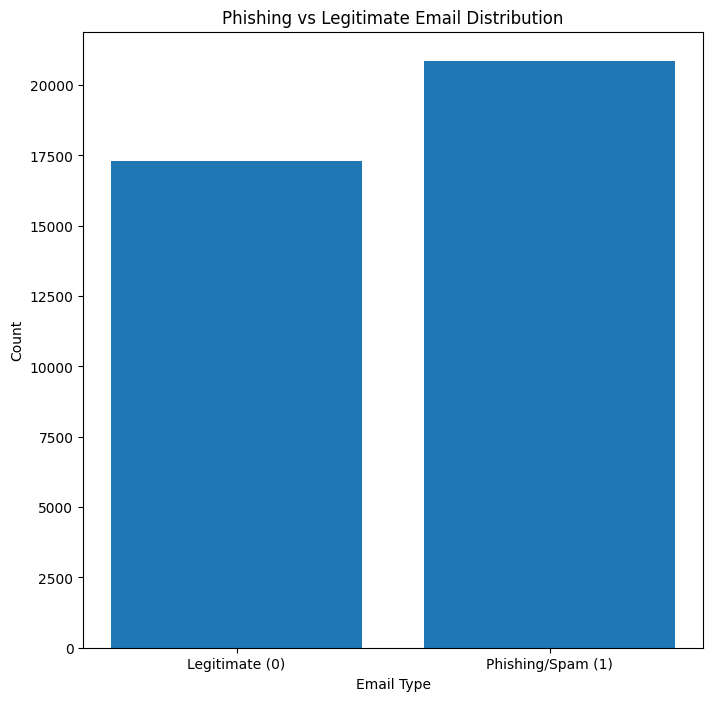

Dataset Shape: (38164, 2)
label
1    20856
0    17308
Name: count, dtype: int64


In [10]:
df = df[['text', 'label']].dropna()
counts = df["label"].value_counts().sort_index()
labels = ["Legitimate (0)", "Phishing/Spam (1)"]

plt.figure(figsize=(8,8))
plt.bar(labels, counts)
plt.xlabel("Email Type")
plt.ylabel("Count")
plt.title("Phishing vs Legitimate Email Distribution")
plt.show()
print("Dataset Shape:", df.shape)
print(df['label'].value_counts())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


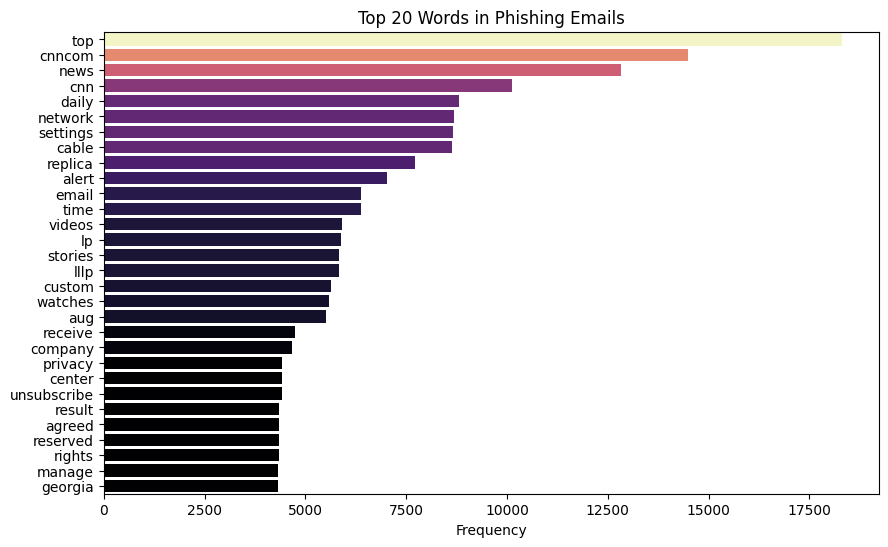

In [18]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('hinglish'))  #e.g., "the", "is", "and"

# Combine all phishing emails: Joins all texts into one string → converts to lowercase → splits into words
phishing_words = ' '.join(df[df['label']==1]['text']).lower().split() #Selects only phishing emails (where label == 1)

filtered_words = [word for word in phishing_words if word.isalpha() and word not in stop_words] #Alphabetic words (removes numbers, punctuation)

word_freq = Counter(filtered_words).most_common(30)

# Barplot of top words
words, counts = zip(*word_freq)  #Unpacks the 20 most common word–count pairs into two separate lists: words and counts
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words),hue =list(counts), palette='magma',legend=False)
plt.title('Top 20 Words in Phishing Emails')
plt.xlabel('Frequency')
plt.show()

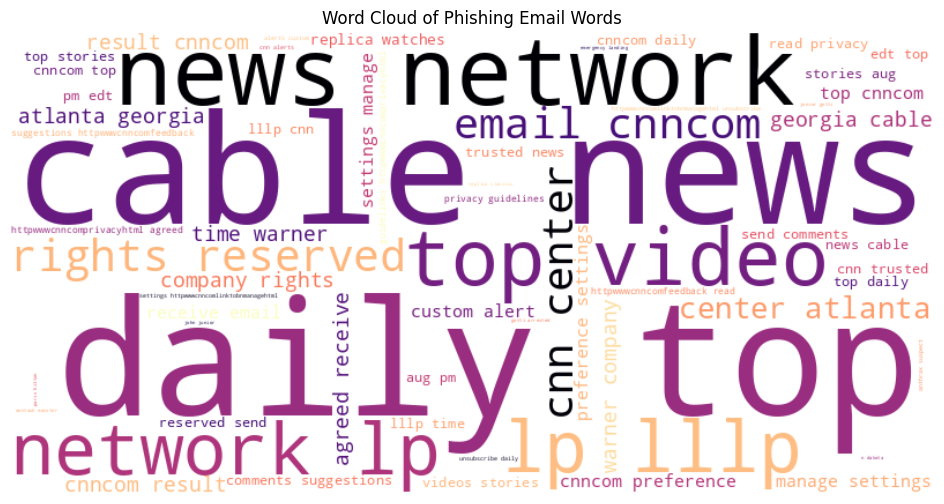

In [19]:
from wordcloud import WordCloud

# Join all filtered phishing words into a single string
wordcloud_text = ' '.join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing Email Words')
plt.show()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [14]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform X_train
X_train_vectorized = vectorizer.fit_transform(X_train)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

print("Shape of X_train_resampled:", X_train_resampled.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)
print("Class distribution after SMOTE:", pd.Series(y_train_resampled).value_counts())

Shape of X_train_resampled: (33424, 212838)
Shape of y_train_resampled: (33424,)
Class distribution after SMOTE: label
1    16712
0    16712
Name: count, dtype: int64


## Train and Evaluate Multinomial Naive Bayes classifier


Train a Multinomial Naive Bayes classifier using the resampled training data (`X_train_resampled`, `y_train_resampled`) and evaluate its performance on the test set (`X_test_vectorized`, `y_test`) using accuracy, classification report, and confusion matrix.

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize and train the Multinomial Naive Bayes classifier
mnb = MultinomialNB()
mnb.fit(X_train_resampled, y_train_resampled)

# Transform the test data using the *same* fitted vectorizer
X_test_vectorized = vectorizer.transform(X_test)

# Make predictions on the test set
y_pred = mnb.predict(X_test_vectorized)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9658063670902659

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      3489
           1       1.00      0.94      0.97      4144

    accuracy                           0.97      7633
   macro avg       0.97      0.97      0.97      7633
weighted avg       0.97      0.97      0.97      7633


Confusion Matrix:
 [[3482    7]
 [ 254 3890]]


## Train and Evaluate Logistic Regression


Train a Logistic Regression classifier using the resampled training data (`X_train_resampled`, `y_train_resampled`) and evaluate its performance on the test set (`X_test_vectorized`, `y_test`) using accuracy, classification report, and confusion matrix.


Logistic Regression - Accuracy: 0.9950216166644832

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3489
           1       0.99      1.00      1.00      4144

    accuracy                           1.00      7633
   macro avg       1.00      0.99      0.99      7633
weighted avg       1.00      1.00      1.00      7633


Logistic Regression - Confusion Matrix:
 [[3460   29]
 [   9 4135]]


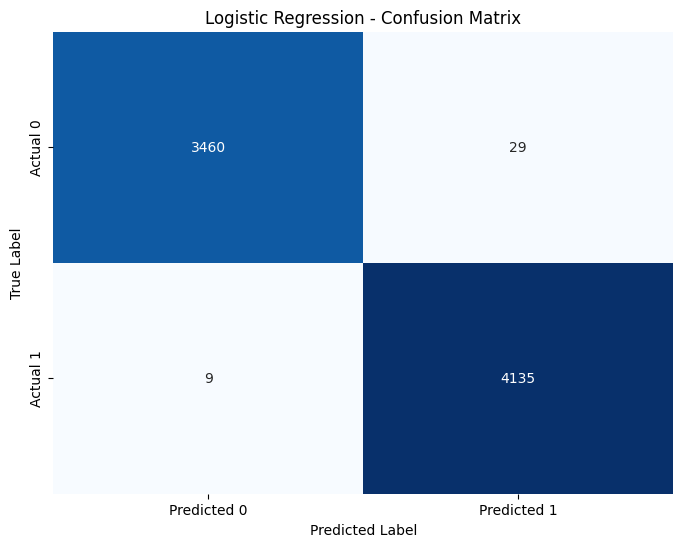

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred_log_reg = log_reg.predict(X_test_vectorized)

# Evaluate the model
print("Logistic Regression - Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("\nLogistic Regression - Classification Report:\n", classification_report(y_test, y_pred_log_reg))

# Confusion Matrix
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
print("\nLogistic Regression - Confusion Matrix:\n", cm_log_reg)

# Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

##Train and evaluate Suppport vector machine

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


--- Support Vector Machine Model Evaluation ---
Accuracy: 0.9909603039434036

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3489
           1       0.99      0.99      0.99      4144

    accuracy                           0.99      7633
   macro avg       0.99      0.99      0.99      7633
weighted avg       0.99      0.99      0.99      7633


Confusion Matrix:
 [[3450   39]
 [  30 4114]]


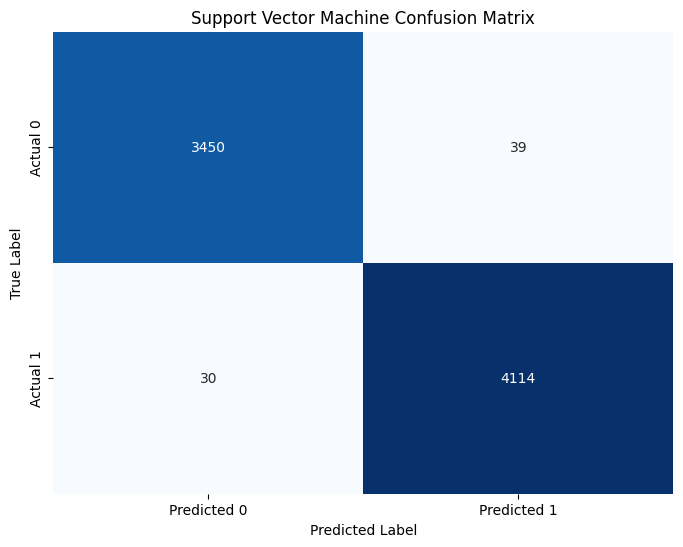

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the Support Vector Machine (SVM) classifier
# Using 'linear' kernel for text classification, and increasing max_iter for convergence.
svm_model = SVC(kernel='linear', random_state=42, max_iter=2000) # Increased max_iter for potential convergence with linear kernel
svm_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the vectorized test set
y_pred_svm = svm_model.predict(X_test_vectorized)

# Evaluate the model
print("--- Support Vector Machine Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))

# Plotting the Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title("Support Vector Machine Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[LightGBM] [Info] Number of positive: 16712, number of negative: 16712
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 7.412021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61067
[LightGBM] [Info] Number of data points in the train set: 33424, number of used features: 12756
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- LightGBM Model Evaluation ---
Accuracy: 0.9804794969212629

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      3489
           1       0.98      0.99      0.98      4144

    accuracy                           0.98      7633
   macro avg       0.98      0.98      0.98      7633
weighted avg       0.98      0.98      0.98      7633


Confusion Matrix:
 [[3394   95]
 [  54 4090]]


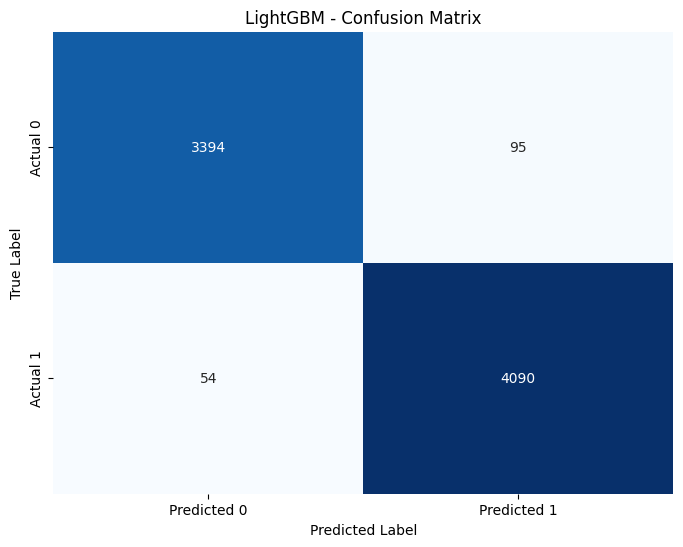

In [17]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Initialize LGBMClassifier
lgbm = LGBMClassifier(n_estimators=200, learning_rate=0.01, max_depth=-1, random_state=42)

# Convert X_train_resampled to float32 as LightGBM expects float data
X_train_resampled_float = X_train_resampled.astype(np.float32)

# Train the model using the resampled and vectorized training data
lgbm.fit(X_train_resampled_float, y_train_resampled)

# Convert X_test_vectorized to float32 for consistency
X_test_vectorized_float = X_test_vectorized.astype(np.float32)

# Make predictions on the vectorized test set
y_pred_lgbm = lgbm.predict(X_test_vectorized_float)

# Evaluate the model
print("--- LightGBM Model Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("\nConfusion Matrix:\n", cm_lgbm)

# Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM - Confusion Matrix')
plt.show()

##K-fold validation  (do not run again)

In [30]:
from sklearn.model_selection import KFold, cross_val_score
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import numpy as np

# 2. Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Create a dictionary of models
models = {
    'Multinomial Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(kernel='linear', random_state=42, max_iter=2000),# Increased max_iter for potential convergence
    'LightGBM': LGBMClassifier(n_estimators=200, learning_rate=0.01, max_depth=-1, random_state=42)
}

# 4. Initialize SMOTE
smote_cv = SMOTE(random_state=42)

# 5. Define scoring metrics
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

results = {}

print("--- K-Fold Cross-Validation Results ---")

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    # 6a. Construct a make_pipeline
    # The CountVectorizer will be fitted on each fold's training data, and then used to transform both train and test.
    # SMOTE will be applied to the vectorized training data within each fold.
    pipeline = make_pipeline(CountVectorizer(), smote_cv, model)

    # 6b. Use cross_val_score to evaluate the pipeline
    cv_scores = {}
    for metric in scoring_metrics:
        scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=metric, n_jobs=-1)
        cv_scores[metric] = scores
        print(f"  {metric.replace('_weighted', '').capitalize()}: Mean = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")
    results[model_name] = cv_scores

print("\n--- Cross-Validation Summary ---")
for model_name, scores_dict in results.items():
    print(f"\nModel: {model_name}")
    for metric, scores in scores_dict.items():
        print(f"  {metric.replace('_weighted', '').capitalize()}: Mean = {np.mean(scores):.4f} (Std: {np.std(scores):.4f})")

--- K-Fold Cross-Validation Results ---

Evaluating Multinomial Naive Bayes...
  Accuracy: Mean = 0.9598, Std = 0.0021
  Precision: Mean = 0.9629, Std = 0.0018


KeyboardInterrupt: 

##**Overfitting Mitigation**





## Refine Model Hyperparameters for Regularization




In [18]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# 1. Initialize Logistic Regression with stronger L2 regularization
log_reg_regularized = LogisticRegression(
    C=0.1,
    penalty='l2',
    solver='liblinear',
    max_iter=1000,
    random_state=42
)
print("Logistic Regression model initialized with stronger regularization.")

# 2. Initialize LGBMClassifier with reduced complexity and regularization
lgbm_regularized = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5, # Reduced complexity
    lambda_l1=1.0, # L1 regularization
    lambda_l2=1.0, # L2 regularization
    random_state=42
)
print("LightGBM model initialized with reduced complexity and regularization.")

# 3. Initialize SVC with stronger regularization and increased max_iter
svm_regularized = SVC(
    kernel='linear',
    C=0.1, # Stronger regularization
    max_iter=5000, # Increased iterations for convergence
    random_state=42
)
print("SVC model initialized with stronger regularization and increased iterations.")

Logistic Regression model initialized with stronger regularization.
LightGBM model initialized with reduced complexity and regularization.
SVC model initialized with stronger regularization and increased iterations.


##Re -evaluating K_ Fold ( do not RUN again)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizerompl
from sklearn.decomposition import TruncatedSVD # Import TruncatedSVD
from sklearn.naive_bayes import ComplementNB # Import ComplementNB
import numpy as np

# 1. Models initialized with stronger regularization (from previous step)
# log_reg_regularized, lgbm_regularized, svm_regularized are already defined

# 2. Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Create a dictionary of regularized models, excluding Naive Bayes due to incompatibility with TruncatedSVD output
models_regularized = {
    'Logistic Regression (Regularized)': log_reg_regularized,
    'LightGBM (Regularized)': lgbm_regularized,
    'Support Vector Machine (Regularized)': svm_regularized
}

# 4. Initialize SMOTE
smote_cv = SMOTE(random_state=42)

# 5. Initialize TruncatedSVD for dimensionality reduction
# Choose a reasonable number of components. This will depend on the dataset size and sparsity.
# For highly sparse text data, often a few hundred components are effective.
# Here, we'll pick 300 as a starting point. Adjust as needed based on performance.
truncated_svd = TruncatedSVD(n_components=300, random_state=42)

# 6. Define scoring metrics
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

results_regularized_svd = {}

print("--- K-Fold Cross-Validation Results with TruncatedSVD and Regularization ---")

for model_name, model in models_regularized.items():
    print(f"\nEvaluating {model_name}...")
    # Construct a make_pipeline including CountVectorizer, TruncatedSVD, SMOTE, and the model
    # TruncatedSVD will reduce dimensionality after vectorization and before SMOTE/model training
    pipeline = make_pipeline(
        CountVectorizer(),
        truncated_svd, # Apply dimensionality reduction
        smote_cv,
        model
    )

    cv_scores = {}
    for metric in scoring_metrics:
        scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring=metric, n_jobs=-1)
        cv_scores[metric] = scores
        print(f"  {metric.replace('_weighted', '').capitalize()}: Mean = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")
    results_regularized_svd[model_name] = cv_scores

print("\n--- Cross-Validation Summary with TruncatedSVD and Regularization ---")
for model_name, scores_dict in results_regularized_svd.items():
    print(f"\nModel: {model_name}")
    for metric, scores in scores_dict.items():
        print(f"  {metric.replace('_weighted', '').capitalize()}: Mean = {np.mean(scores):.4f} (Std: {np.std(scores):.4f})")

--- K-Fold Cross-Validation Results with TruncatedSVD and Regularization ---

Evaluating Logistic Regression (Regularized)...
  Accuracy: Mean = 0.9847, Std = 0.0018
  Precision: Mean = 0.9848, Std = 0.0018
  Recall: Mean = 0.9847, Std = 0.0018
  F1: Mean = 0.9847, Std = 0.0018

Evaluating LightGBM (Regularized)...
  Accuracy: Mean = 0.9878, Std = 0.0018
  Precision: Mean = 0.9878, Std = 0.0018
  Recall: Mean = 0.9878, Std = 0.0018
  F1: Mean = 0.9878, Std = 0.0018

Evaluating Support Vector Machine (Regularized)...
  Accuracy: Mean = 0.9868, Std = 0.0021
  Precision: Mean = 0.9869, Std = 0.0021
  Recall: Mean = 0.9868, Std = 0.0021


Training Logistic Regression Pipeline...
Training Complete.

--- Logistic Regression (Regularized) Test Set Evaluation ---
Accuracy: 0.9849338399056727

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3489
           1       0.98      0.99      0.99      4144

    accuracy                           0.98      7633
   macro avg       0.99      0.98      0.98      7633
weighted avg       0.99      0.98      0.98      7633


Confusion Matrix:
 [[3399   90]
 [  25 4119]]


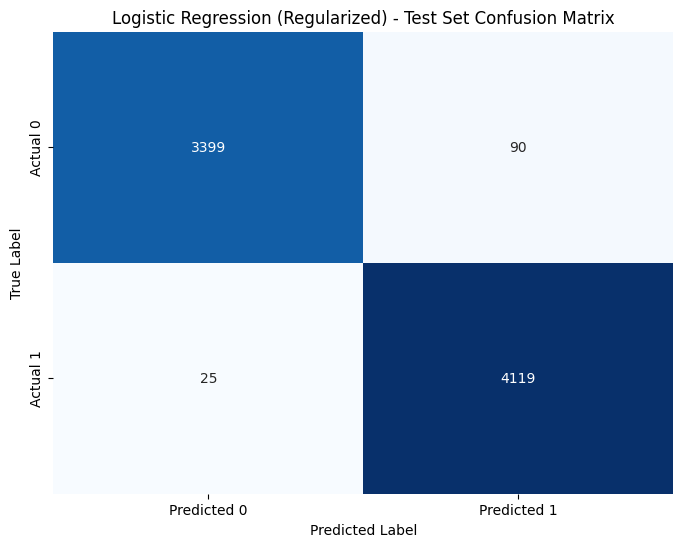

In [36]:
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

# 1. TruncatedSVD object
truncated_svd_test = TruncatedSVD(n_components=300, random_state=42)

# 2. Create a Pipeline for Logistic Regression
log_reg_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('svd', truncated_svd_test),
    ('smote', SMOTE(random_state=42)),
    ('classifier', log_reg_regularized) # Using the already defined regularized model
])

# 3. Fit the pipeline to the entire X_train and y_train datasets
print("Training Logistic Regression Pipeline...")
log_reg_pipeline.fit(X_train, y_train)
print("Training Complete.")

# 4. Use the fitted pipeline to make predictions on the X_test data
y_pred_log_reg_test = log_reg_pipeline.predict(X_test)

# 5. Evaluate the model
print("\n--- Logistic Regression (Regularized) Test Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log_reg_test))

# Confusion Matrix
cm_log_reg_test = confusion_matrix(y_test, y_pred_log_reg_test)
print("\nConfusion Matrix:\n", cm_log_reg_test)

# 6. Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_reg_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression (Regularized) - Test Set Confusion Matrix')
plt.show()

Training LightGBM Pipeline...
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Number of positive: 16712, number of negative: 16712
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 76500
[LightGBM] [Info] Number of data points in the train set: 33424, number of used features: 300
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0

--- LightGBM (Regularized) Test Set Evaluation ---
Accuracy: 0.9903052535045198

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99      3489
           1       0.99      1.00      0.99      4144

    accuracy                           0.99      7633
   macro avg       0.99      0.99      0.99      7633
weighted avg       0.99      0.99      0.99      7633


Confusion Matrix:
 [[3430   59]
 [  15 4129]]


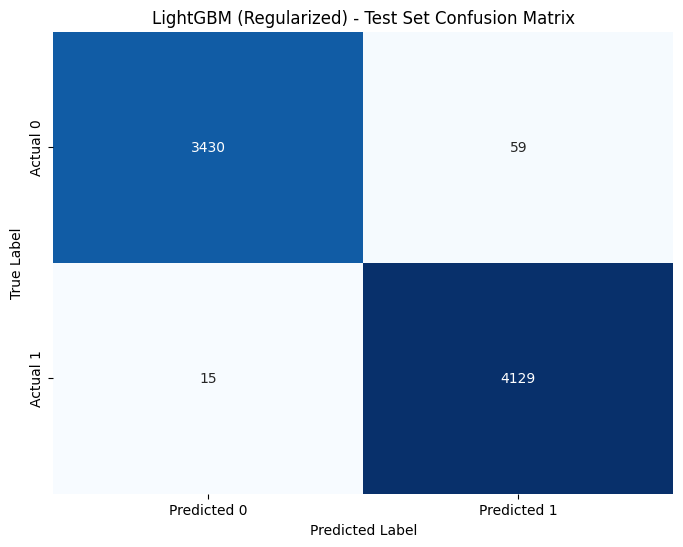

In [19]:
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from lightgbm import LGBMClassifier # Import LGBMClassifier

# TruncatedSVD object (already defined in the previous cell as truncated_svd_test, but redefined for clarity)
truncated_svd_test = TruncatedSVD(n_components=300, random_state=42)

# Re-initialize lgbm_regularized here to ensure it's defined
lgbm_regularized = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5, # Reduced complexity
    lambda_l1=1.0, # L1 regularization
    lambda_l2=1.0, # L2 regularization
    random_state=42
)

# Create a Pipeline for LightGBM
lgbm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('svd', truncated_svd_test),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgbm_regularized) # Using the already defined regularized model
])

# Fit the pipeline to the entire X_train and y_train datasets
print("Training LightGBM Pipeline...")
lgbm_pipeline.fit(X_train, y_train)
print("Training Complete.")

# Use the fitted pipeline to make predictions on the X_test data
y_pred_lgbm_test = lgbm_pipeline.predict(X_test)

# Evaluate the model
print("\n--- LightGBM (Regularized) Test Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lgbm_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lgbm_test))

# Confusion Matrix
cm_lgbm_test = confusion_matrix(y_test, y_pred_lgbm_test)
print("\nConfusion Matrix:\n", cm_lgbm_test)

# Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lgbm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM (Regularized) - Test Set Confusion Matrix')
plt.show()

Training SVM Pipeline...


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training Complete.

--- Support Vector Machine (Regularized) Test Set Evaluation ---
Accuracy: 0.9851958600812263

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      3489
           1       0.98      1.00      0.99      4144

    accuracy                           0.99      7633
   macro avg       0.99      0.98      0.99      7633
weighted avg       0.99      0.99      0.99      7633


Confusion Matrix:
 [[3396   93]
 [  20 4124]]


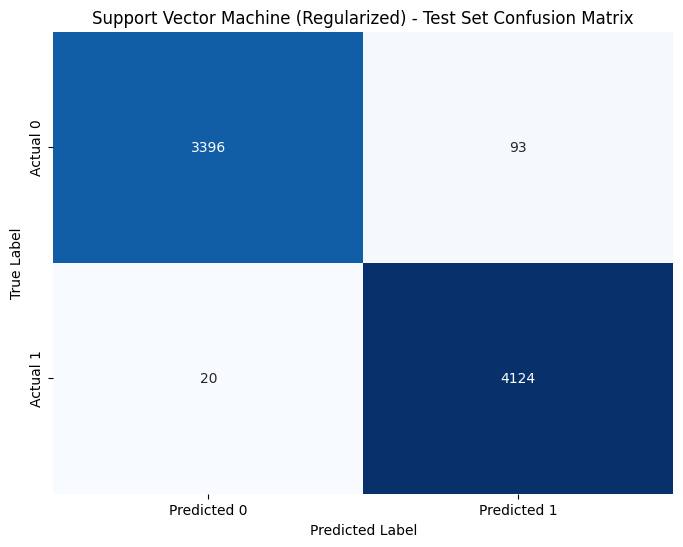

In [38]:
from imblearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC # Import SVC

# TruncatedSVD object (already defined in previous cells)
truncated_svd_test = TruncatedSVD(n_components=300, random_state=42)

# Re-initialize svm_regularized here to ensure it's defined
svm_regularized = SVC(
    kernel='linear',
    C=0.1, # Stronger regularization
    max_iter=5000, # Increased iterations for convergence
    random_state=42
)

# Create a Pipeline for SVM
svm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('svd', truncated_svd_test),
    ('smote', SMOTE(random_state=42)),
    ('classifier', svm_regularized) # Using the already defined regularized model
])

# Fit the pipeline to the entire X_train and y_train datasets
print("Training SVM Pipeline...")
svm_pipeline.fit(X_train, y_train)
print("Training Complete.")

# Use the fitted pipeline to make predictions on the X_test data
y_pred_svm_test = svm_pipeline.predict(X_test)

# Evaluate the model
print("\n--- Support Vector Machine (Regularized) Test Set Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_test))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm_test))

# Confusion Matrix
cm_svm_test = confusion_matrix(y_test, y_pred_svm_test)
print("\nConfusion Matrix:\n", cm_svm_test)

# Plotting the Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Support Vector Machine (Regularized) - Test Set Confusion Matrix')
plt.show()

In [ ]:
# ============================
# 6. Hyperparameter Tuning
# ============================
from imblearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
lgbm_pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('svd', truncated_svd_test),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgbm_regularized) # Using the already defined regularized model
])


# Define parameter grid for LightGBM
param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__max_depth': [-1, 10, 20],
    'classifier__subsample': [0.7, 0.8, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 1.0]
}

# Randomized search
rand_search = RandomizedSearchCV(
    lgbm_pipeline,
    param_distributions=param_grid_lgbm,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("Running hyperparameter tuning...")
rand_search.fit(X_train, y_train)

print("Best Parameters:", rand_search.best_params_)
print("Best CV Score:", rand_search.best_score_)

# Update pipeline with best parameters
best_pipeline = rand_search.best_estimator_

# Save tuned pipeline
joblib.dump(best_pipeline, "lgbm_model_pipeline.pkl")

Running hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [20]:
import joblib

# Extract individual components from the trained pipeline
vectorizer_model = lgbm_pipeline.named_steps['vectorizer']
svd_model = lgbm_pipeline.named_steps['svd']
lgbm_model = lgbm_pipeline.named_steps['classifier']

# Define filenames for each component
vectorizer_filename = 'count_vectorizer.pkl'
svd_filename = 'truncated_svd.pkl'
lgbm_classifier_filename = 'lgbm_classifier.pkl'

# Save each component separately
joblib.dump(vectorizer_model, vectorizer_filename)
joblib.dump(svd_model, svd_filename)
joblib.dump(lgbm_model, lgbm_classifier_filename)

print(f"CountVectorizer saved to {vectorizer_filename}")
print(f"TruncatedSVD saved to {svd_filename}")
print(f"LGBMClassifier saved to {lgbm_classifier_filename}")

print("\nTo load and use these models for prediction, you would do the following:")
print("1. Load the vectorizer: `loaded_vectorizer = joblib.load('count_vectorizer.pkl')`")
print("2. Load the SVD: `loaded_svd = joblib.load('truncated_svd.pkl')`")
print("3. Load the classifier: `loaded_lgbm_classifier = joblib.load('lgbm_classifier.pkl')`")
print("4. For new text data (`new_text`): `transformed_text = loaded_svd.transform(loaded_vectorizer.transform([new_text]))`")
print("5. Make prediction: `prediction = loaded_lgbm_classifier.predict(transformed_text)`")

CountVectorizer saved to count_vectorizer.pkl
TruncatedSVD saved to truncated_svd.pkl
LGBMClassifier saved to lgbm_classifier.pkl

To load and use these models for prediction, you would do the following:
1. Load the vectorizer: `loaded_vectorizer = joblib.load('count_vectorizer.pkl')`
2. Load the SVD: `loaded_svd = joblib.load('truncated_svd.pkl')`
3. Load the classifier: `loaded_lgbm_classifier = joblib.load('lgbm_classifier.pkl')`
4. For new text data (`new_text`): `transformed_text = loaded_svd.transform(loaded_vectorizer.transform([new_text]))`
5. Make prediction: `prediction = loaded_lgbm_classifier.predict(transformed_text)`


In [ ]:
import joblib

# Define the filename for the pickled model
model_filename = 'lgbm_model_pipeline.pkl'

# Save the lgbm_pipeline object to a .pkl file
joblib.dump(lgbm_pipeline, model_filename)

print(f"LightGBM pipeline saved to {model_filename}")

LightGBM pipeline saved to lgbm_model_pipeline.pkl


In [ ]:
import zipfile
from google.colab import files

# Define the name for the zip file
zip_filename = 'lgbm_model_pipeline.zip'

# Create a zip archive containing the pickled model
with zipfile.ZipFile(zip_filename, 'w') as zf:
    zf.write(model_filename, arcname=model_filename)

print(f"'{model_filename}' has been zipped into '{zip_filename}'")



'lgbm_model_pipeline.pkl' has been zipped into 'lgbm_model_pipeline.zip'
